## Experiment 3 - CNN 

- [ ] Use a MFCC of 40 bands
- [ ] over the middle 5 seconds of each clip
- [ ] if the clip duration is < 5secs, repeat the same clip until is 5 secs

- [ ] Use a CNN layer




### Interesting notes

https://musicinformationretrieval.com/


In [1]:
## Remove files that are corrupted in audio_test

import os
import os.path

for file in ['audio_test/0b0427e2.wav', 'audio_test/6ea0099f.wav', 'audio_test/b39975f5.wav']:
    if os.path.isfile(file):
        os.remove(file)


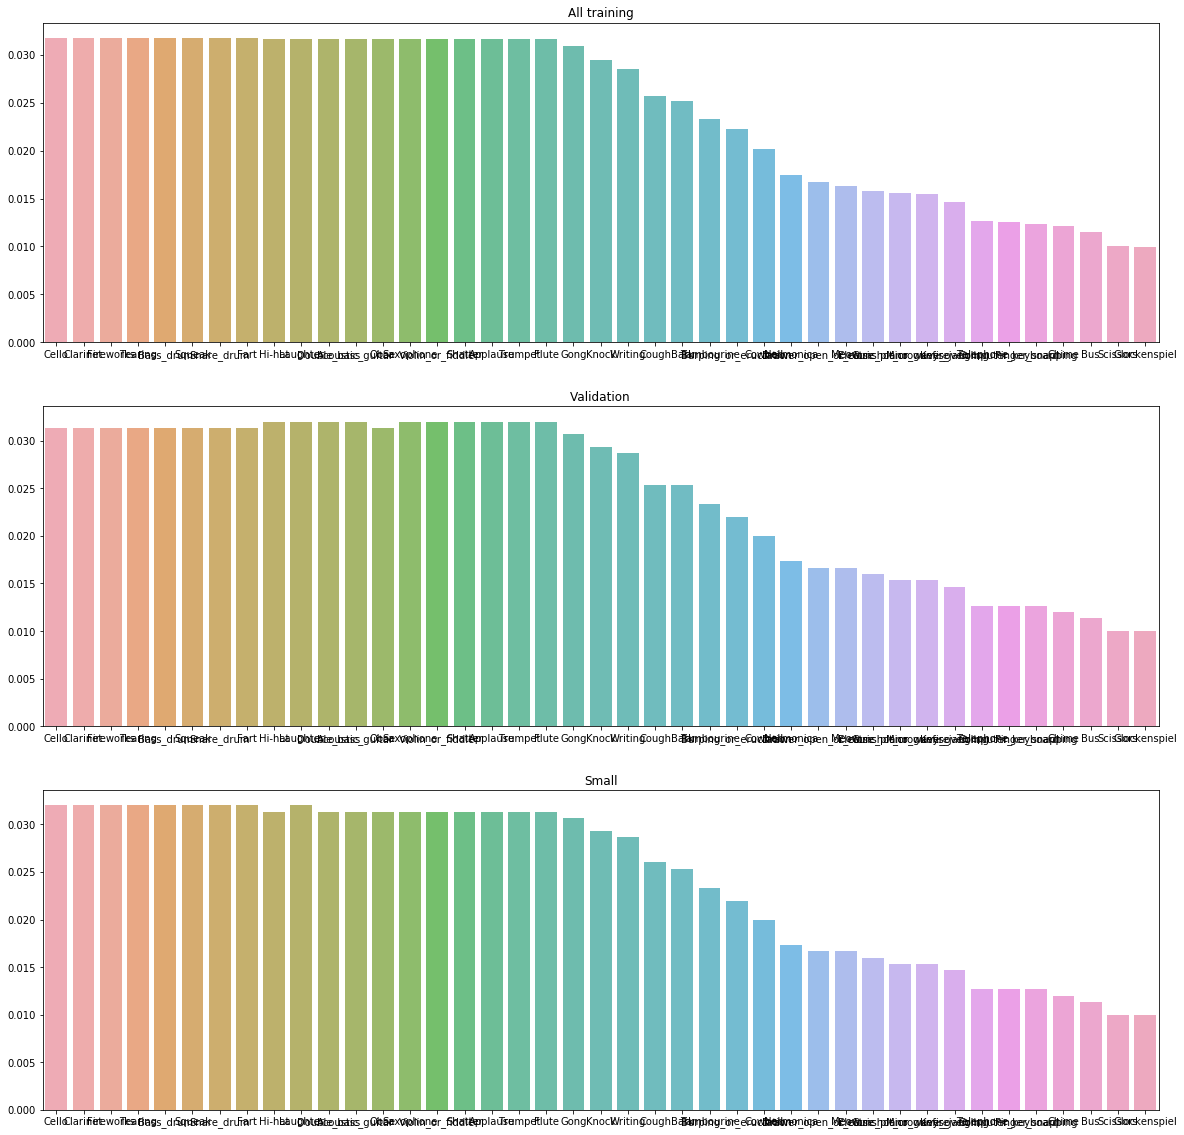

In [2]:
%matplotlib inline


EXPERIMENT_NAME = "cnn/"

import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Read the CSV file
df = pd.read_csv('train.csv')
df['label'] = df['label'].astype('category')

## Create a BIG train dataset and a validation
train, validation = train_test_split(df, test_size=1500, random_state=1, stratify=df['label'])

## from the big train, we create a small one to make fastest computations
_, small = train_test_split(train, test_size=1500, random_state=1, stratify=train['label'])

def plot_categorical_variable_distribution(serie, ax, title="Distribution", order = None):
    count  = serie.value_counts(normalize=True)
    ax.set_title(title)
    sns.barplot(count.index, count.values, alpha=0.8, order=order, ax=ax)

## Print the repetition of each class, to be sure that the distribution is acceptable for validation and small sets
fig, axes = plt.subplots(3, 1, figsize=(20, 20))
order = train['label'].value_counts().index

plot_categorical_variable_distribution(train['label'], axes.flat[0], title= "All training", order=order)
plot_categorical_variable_distribution(validation['label'], axes.flat[1], title= "Validation", order=order)
plot_categorical_variable_distribution(small['label'], axes.flat[2], title = "Small", order=order)



## process audio

1. for each filename
   1. Load it
   2. if the size is < 5 seconds, we repeat the song until the lentgth > of 5 secos
   3. we get only 5 seconds of the clip (the ones in the center)
   3. Extract mean of zerospectral centrol



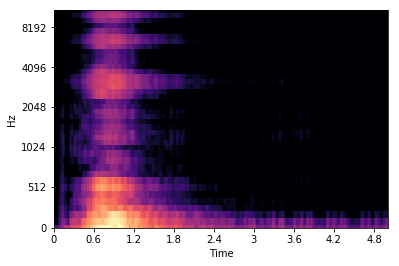

In [3]:
## Load wavefiles and calculate some features
import librosa
import librosa.display
import numpy as np
import math

def load_signal(filename):
    return librosa.load(filename)

SECS = 5
def center_signal(signal, sr, center_duration=SECS):
    """
    Loads the wav file and crops from the center it to have center_duration
    
    if the wav file is shorter than center_duration, repeat the data until is enough
    """
    
    duration = signal.shape[0]/ sr

    if duration < SECS:
        n_repeat = math.ceil(SECS / duration)
        signal = np.repeat(signal, n_repeat)
        duration = signal.shape[0]/ sr
        

    if duration > SECS:
        start = (duration / 2.0) - (SECS/2.0)
        end = (duration / 2.0) + (SECS/2.0)
        
        start = int(start * sr)
        end = int(end * sr)
        
        signal = signal[start:end]

    return signal, sr
    
def get_features_for_file(filename):
    signal, sr = load_signal(filename)
    signal, sr = center_signal(signal, sr, SECS)
        
    signal = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=40)
    return librosa.power_to_db(signal, ref=np.max)

filename = "audio_train/18e0f7ac.wav"

p = get_features_for_file(filename)
p.shape

librosa.display.specshow(p,y_axis='mel', x_axis='time')

import IPython.display as ipd
ipd.Audio(filename)

# Generate features

We create 4 x,y

`x`,`y` -> small dataset

`x_validation`, `y_validation`

`x_full`, `y_full`

`x_test`

In [4]:
import os.path


## for each filename get the 
def get_features(x):
    x = map(get_features_for_file, x)
    x = np.array(list(x))

    return x


def process_csv(data, file):
    """
    Loads the wavfiles from each row
    Transforms them
    """
    
    x = data['fname']
    x = map(lambda f: "audio_train/" + f, x.values)
    y = np.array(data['label'].cat.codes)


    if not os.path.isfile(file): 
        x = get_features(x)
        np.save(file, x)
    else:
        x = np.load(file)    
    
    return x, y

x, y = process_csv(small, "%s/small_x.npy" % EXPERIMENT_NAME)
x_validation, y_validation = process_csv(validation, "%s/validation_x.npy" % EXPERIMENT_NAME)
x_full, y_full = process_csv(train, "%s/full_x.npy" % EXPERIMENT_NAME)



In [5]:
import glob
test_files = glob.glob("audio_test/*.wav")

def load_test(filename):
    if not os.path.isfile(filename):
        x = get_features(test_files)
        np.save(filename, x)
    else:
        x = np.load(filename)
    return x

x_test = load_test("%s/test.npy" % EXPERIMENT_NAME)

## Simple CNN - Only Dense layer

Create the simplest model with just 2 Full Connected layers


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

N_CATEGORIES = int(np.max(y) + 1)

class Net_old(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.con1 = nn.Conv1d(40, 80, 3)
        self.maxpool1 = nn.MaxPool1d(3, stride=2)
        self.con2 = nn.Conv1d(80, 160, 3)
        self.con2_bn = nn.BatchNorm1d(160)

        self.fc1 = nn.Linear(8160, 4000)
        self.fc2 = nn.Linear(4000, 2000)
        self.fc4_bn = nn.BatchNorm1d(2000)
        self.fc3 = nn.Linear(2000, 1024)
        self.fc4_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc4_bn = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512, N_CATEGORIES)

    def forward(self, x):
        
        x = self.con1(x)
        x = self.maxpool1(x)
        x = self.con2(x)
        x = self.con2_bn(x)
        x = self.maxpool1(x)
        x = x.view(-1, 8160)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.relu(self.fc4_bn(self.fc4(x)))

        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

class Net_1D(nn.Module):
    def __init__(self):
        super(Net_1D, self).__init__()
        self.conv1 = nn.Conv1d(40, 80, kernel_size=5)
        self.conv2 = nn.Conv1d(80, 160, kernel_size=5)
        self.conv2_drop = nn.Dropout()
        self.fc1 = nn.Linear(8160, 4000)
        
        self.fc2 = nn.Linear(4000, 1000)
        self.fc3 = nn.Linear(1000, N_CATEGORIES)

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 8160)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

class Net_2D(nn.Module):
    def __init__(self):
        super(Net_2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3)
        self.conv2 = nn.Conv2d(20, 40, 3)
        self.conv3 = nn.Conv2d(40, 50, 3)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(3750, 2000)        
        self.fc2 = nn.Linear(2000, 512)
        self.fc3 = nn.Linear(512, N_CATEGORIES)

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 3750)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


model = Net_2D().to(device)
print("using %s" % device)

num_paramets = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model, num_paramets)
#print("traiable parameters: " , count_parameters(model))    

RuntimeError: cuda runtime error (30) : unknown error at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/THCTensorRandom.cu:25

## Creating datasets 

Pytorch uses datasets and loaders for creating mini batches

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

def convert_categorical_to_one_hot(y):
    return pd.get_dummies(y).values

def create_dataset(x, y):
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y.astype(np.uint8)).long()
    
    return TensorDataset(x, y)

BATCH_SIZE = 750

small = create_dataset(x, y)
validation = create_dataset(x_validation, y_validation)
full = create_dataset(x_full, y_full)
test = TensorDataset(torch.from_numpy(x_test))

small_loader = torch.utils.data.DataLoader(small, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
full_loader = torch.utils.data.DataLoader(full, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:

def train(model, device, train_loader, optimizer, epoch, log_interval = 10):
    model.train()
    total_loss = 0
    iterations = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        iterations += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        total_loss += loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return total_loss / float(iterations)
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


## On kaggle the function used is MapK@3

In [ ]:
import ml_metrics as metrics

def predict(x):
    with torch.no_grad():
        if type(x) == torch.Tensor:
            x = x.float().to(device)
        else:
            x = torch.from_numpy(x).float().to(device)
        output = model(x).cpu().detach().numpy()
    
    indices = np.argsort(-output)
    return indices


def get_top_predict(indices, k=3):
    return list(map(lambda row: [row[0], row[1], row[2]], indices))

def score(x, y):
    actual = y.tolist()
    actual = map(lambda x: [x], actual)
    
    indices = predict(x)
    
    y_hat = get_top_predict(indices, k=3)
    return metrics.mapk(actual, y_hat, 3)


# Start training

we are using TensorBoardX to send the losses and see nices charts :)

`tensorboard --logdir runs`

In [ ]:
LEARNING_RATE = 0.00001
MOMENTUM = 0.80
EPOCHS = 700

#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#optimizer = optim.Adagrad(model.parameters(),lr=0.00001)
#optimizer = torch.optim.LBFGS(model.parameters())

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

from tensorboardX import SummaryWriter
writer = SummaryWriter()

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, device, full_loader, optimizer, epoch)
    validation_loss = test(model, device, validation_loader)
    s = score(x_validation, y_validation)
    
    writer.add_scalar('data/train_loss', train_loss, epoch)
    writer.add_scalar('data/test_loss', validation_loss, epoch)
    writer.add_scalar('data/score', s, epoch)
#    scheduler.step()

torch.save(model, './cnn_1d')

In [ ]:
train_score = score(x_full, y_full)
validation_score = score(x_validation, y_validation)

print("Train score: %s\nvalidation score %s" % (train_score, validation_score))

## Prepare for submission!


In [ ]:
indices = []

for data in test_loader:
    predicted = predict(data[0])
    for i in predicted:
        indices.append(i)

result = get_top_predict(indices)

from os.path import basename

categories = {i: x for (i,x) in enumerate(df['label'].cat.categories) }

label = ["%s %s %s" % (categories[result[0]], categories[result[1]], categories[result[2]]) for result in result]

submission = pd.DataFrame(
    {'fname': list(map(lambda x: basename(x), test_files)),
     'label': label
    })

missing_data = pd.DataFrame(
    {'fname': ['0b0427e2.wav', '6ea0099f.wav', 'b39975f5.wav'],
     'label': 3 * ['Laughter Hi-Hat Flute']
    })

submission = submission.append(missing_data, ignore_index=True)

file = 'submission.csv'
if os.path.isfile(file):
    os.remove(file)

submission.to_csv("submission.csv", index=False)

submission.head()

In [ ]:
!kaggle competitions submit -c freesound-audio-tagging -f submission.csv -m "CNN 1D only copies from mnist"
